## Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Nous disposons d'un ensemble de données de 17092 images de cellules normales du sang périphérique, les images sont réparties sur 8 classes de types distincts à savoir : 'basophil','eosinophil', 'erythroblast', 'immature granulocytes', 'lymphocyte', 'monocyte', 'neutrophil' et 'platelet'.

Dans ce notebook on va effectuer un audit général de nos images et quelques visualisations.  

## 1. Charger les données

In [2]:
# Pour connecter colab au Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from termcolor import colored
import random
from datetime import datetime

import glob
import os

import cv2 ## Package pour lire nos images
from PIL import Image ## Importer ce package pour pouvoir voir le format de l'image
import skimage.exposure

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.preprocessing import MinMaxScaler

## Chemin pour aller récupérer les images stockées dans le dossier 'PBC_dataset_normal_DIB'
path ='/content/drive/MyDrive/dataset/PBC_dataset_normal_DIB/'

## Créer une liste où stocker les noms des images de nos 8 différentes classes
Classes = []
for element in os.listdir(path):
    img = os.listdir(path + element)
    Classes.append(img)


# importer toutes les images des 8 différentes classes et les stocker dans un array images
images = []
for element in os.listdir(path) :
    for img in glob.glob(path +  element + '/' + '*.jpg'): 
        imge = cv2.imread(img)
        images.append(imge)


## 2. Audit

### 2.1. Regarder la répartition de nos données sur les 8 classes 

In [ ]:
# Afficher la taille de nos classes et le pourcentage de chacune d'entre elles dans un DataFrame
type_cellule=['basophil','eosinophil', 'erythroblast','immature granulocytes','lymphocyte','monocyte','neutrophil',
              'platelet']
Total_Number = []
Percentage = []
for i, Classe in zip(range(len(Classes)),type_cellule):
    Total_Number.append(len(Classes[i]))
    Percentage.append(round(len(Classes[i])/17092 *100,2))

dictionnaire = {'Type de Cellule': [i for i in type_cellule],
                'Total_images' : [j for j in Total_Number],
                '%' : [perc for perc in Percentage]
                 }

DF = pd.DataFrame(data = dictionnaire, columns=dictionnaire.keys())

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")

g = sns.catplot(y='Type de Cellule',x='Total_images',hue='Type de Cellule' ,data=DF,kind='bar',dodge=False,height=8)
g.fig.set_figwidth(12)
g.fig.set_figheight(6)
g.set_yticklabels(["BA", "EO", "ER","IG","LY","MO","NEU","PLT"])
#plt.legend(labels = [name for name in type_cellule],loc='center right',bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.xlabel("Nombre d'images",size=14)
plt.ylabel("Type de Cellule",size=14);

##### Taille des images

In [ ]:
# Taille de nos images
for img in images :
    h, w, c = img.shape # on peut utiliser également size qui nous renvoit (h*w*c)
print("height  :", h)
print("width   :", w)
print("channel :", c)

# Si jamais dans nos données on a des images avec des tailles différentes des autres, récupérer le nom des images et le 
# stocker dans une liste !
img_other_size = []    
for element, Classe in zip(os.listdir(path),Classes) :
    for img, imge in zip(glob.glob(path+element+'/'+'*.jpg'), Classe) : 
        if cv2.imread(img).shape != (h,w,c) :
            img_other_size.append(imge)

print("\n")

if not img_other_size :
    print(colored("Toutes nos images ont la même taille",attrs=['bold']))
else :
    print(colored(len(img_other_size),attrs=['bold']),
          "images possèdent une taille différente de la taille des autres images !")

**Il faut changer la taille des images de la liste img_other_size afin d'uniformiser le dataset**

##### Format des images

In [ ]:
path ='/content/drive/MyDrive/dataset/PBC_dataset_normal_DIB/'

In [ ]:
## format de nos images
for element in os.listdir(path) :
    for img in glob.glob(path+element+'/'+'*.jpg'): 
        format_image = Image.open(img).format

print("le format de nos images est :", format_image)

# Si il y'a des images avec un format différent des autres images, on va les récupérer et ensuite les stocker dans la liste
# img_other_format        
img_other_format = []

for element, Classe in zip(os.listdir(path),Classes) :
    for img, imge in zip(glob.glob(path+element+'/'+'*.jpg'), Classe) : 
        if Image.open(img).format != 'JPEG' :
            img_other_format.append(imge)

print("\n")

if not(img_other_format) :
    print(colored("toutes nos images ont le même format !",attrs=['bold']))
else :
    img_other_format

### 2.2. Visalisation des différents classes de cellules

In [ ]:
#------- Afficher pour chaque type de cellules une image, qu'on récupére du manière aléatoire ---------#
# selectionner une cellule de chaque type de classe et les visualiser avec plt.imshow
img_random = []
for i in range(len(Classes)) :
    for j in range(1):
        img = random.choice(Classes[i])
        img_random.append(img)


noms_classe = ['basophil','eosinophil','erythroblast','immature granulocytes','lymphocyte','monocyte','neutrophil',
               'platelet']

sns.set_theme(style="white")
fig= plt.figure(figsize=(18,20))   
for i in range(len(img_random)):        
    # subplots
    plt.subplot(4, 4, i+1)   
    # Afficher l'image en couleur
    plt.imshow(cv2.cvtColor(cv2.imread(path+os.listdir(path)[i]+'/'+img_random[i],cv2.IMREAD_COLOR),cv2.COLOR_BGR2RGB));
    
    # set the title to subplots
    plt.gca().set_title(noms_classe[i],size=20) ;
    

## 3. Preprocessing

### 3.1. Distributions des coleurs et la balance des blancs 

In [ ]:
def histogramOpenCV(img_co, img_gr, white_hi):
    _, axis = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))
    axis[0][0].imshow(img_co)
    axis[0][1].set_title('Histogram')
    axis[0][0].set_title('Image')
    rgbcolors = ['red', 'green', 'blue']
    for i,col in enumerate(rgbcolors):
        histr = cv2.calcHist([img_co],[i],None,[256],[0,256])
        axis[0][1].plot(histr,color = col)
    
    axis[1][0].imshow(img_gr,'gray')
    axis[1][0].set_title("Image en noir et blanc")
    axis[1][1].plot(white_hi)
    axis[1][1].set_title("white")
    
#Lecture des images en mode noir et blanc ou couleurs
#transformation de l'image couleur en noir et blanc

# Créer des listes vides pour stocker les différentes lectures de nos images noir et blanc, couleur 
Img_gray = [] 
Img_color = [] 
White_hist = []

for i in range(len(img_random)) :
    
    img = path+os.listdir(path)[i]+'/'+img_random[i] # Chemin où se trouve l'image
    
    img_gray = cv2.imread(img, cv2.IMREAD_GRAYSCALE)  # str(img)
    Img_gray.append(img_gray)
    
    img_color = cv2.imread(img, cv2.IMREAD_COLOR)  # # str(img)
    Img_color.append(img_color)
    
    img_gray2 = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
    
    #histogramme en noir et blanc
    white_hist = cv2.calcHist([img_gray2],[0],None,[256],[0,256])
    White_hist.append(white_hist)

## Affichage des images
for i in range (len(img_random)):
    histogramOpenCV(Img_color[i], Img_gray[i], White_hist[i])

### 3.2. Transformation de l'image de RGB -> HSV

In [ ]:
Hsv = [] 

#Déclaration des couleurs des courbes
color = ('r','g','b')
#Déclaration des noms des courbes.
labels = ('h','s','v')

for j in range(len(img_random)) :   
    img = path+os.listdir(path)[j]+'/'+img_random[j]
    hsv = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2HSV)
    Hsv.append(hsv)
    
for j in range(len(img_random)) :
    _, axis = plt.subplots(ncols=3, figsize=(18, 5))
    for i,col in enumerate(color):
        #Hist prend la valeur de l'histogramme de hsv sur la canal i.
        hist_hsv = cv2.calcHist([Hsv[j]],[i],None,[256],[0,256])

        # Plot de hist.
        #plt.subplot(223),
        axis[2].plot(hist_hsv,color = col,label=labels[i])
        axis[2].set_title('HSV')
        axis[2].legend()
        #axis[2].xlim([0,256])

    axis[0].imshow(Img_color[j], 'gray')
    axis[0].set_title("image en coleur")
    axis[1].imshow(Hsv[j], 'gray')
    axis[1].set_title('hsv');


### 3.2. Transformation de l'image de RGB -> LAB


In [ ]:
Lab = []

#Déclaration des couleurs des courbes
color = ('r','g','b')
#Déclaration des noms des courbes.
labels = ('l','a','b')
for j in range(len(img_random)) :   
    img = path+os.listdir(path)[j]+'/'+img_random[j]
    lab = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2LAB)
    Lab.append(lab)
    
for j in range(len(img_random)) :
    _, axis = plt.subplots(ncols=3, figsize=(18, 5))
    for i,col in enumerate(color):
        #Hist prend la valeur de l'histogramme de hsv sur la canal i.
        hist_lab = cv2.calcHist([Lab[j]],[i],None,[256],[0,256])

        axis[2].plot(hist_lab,color = col,label=labels[i])
        axis[2].set_title('LAB')
        axis[2].legend()

    axis[0].imshow(Img_color[j], 'gray')
    axis[0].set_title("image en coleur")
    axis[1].imshow(Lab[j], 'gray')
    axis[1].set_title('lab');


### 3.3. Etude des contours 

####  Méthode Canny

In [ ]:
from skimage import feature

# Lire les images affichées ci-dessus 
imge_array = []
M = []
for i in range(len(img_random)) :
    imge = cv2.imread(path+os.listdir(path)[i]+'/'+img_random[i],cv2.IMREAD_COLOR)#,cv2.IMREAD_COLOR, cv2.COLOR_BGR2HSV, cv2.COLOR_BGR2LAB )
    m = np.zeros((imge.shape[0],imge.shape[1]))
    m[:,:] = imge[:,:,0]
    imge_array.append(imge)
    M.append(m)

#---------- Appliquer le filtre Canny  ----------#

edges = []
for i in range(len(imge_array)):
    edges.append(feature.canny(M[i], sigma=8)) # On peut jouer sur les valeurs de sigma  

fig = plt.figure(figsize=(18,20))   
for i in range(len(imge_array)) :        
    # subplots
    plt.subplot(4, 4, i+1)   
    # Afficher l'image
    plt.imshow(edges[i], cmap=plt.cm.gray, interpolation='nearest');  
    # set the title to subplots
    plt.gca().set_title(noms_classe[i],size=20) ;

### 2.3. Histogramme des pixels

In [ ]:
fig = plt.figure(figsize=(18,20))   
for i in range(len(imge_array)) :        
    # subplots
    plt.subplot(4, 4, i+1)   
    # Afficher l'image
    plt.hist(imge_array[i].flatten(), bins = 20, density = True , alpha = .5 , edgecolor = 'black', color = 'red');  
    # set the title to subplots
    plt.gca().set_title(noms_classe[i],size=20) ;

## 4. Nettoyage du Background

In [ ]:
import sys
Img_cleaned = []
#Masks = []
#Originals = []
for i in range(len(img_random)):
    img = cv2.imread(path+os.listdir(path)[i]+'/'+img_random[i])
    original = img

    l = int(max(5, 6))  #(5, 6)
    u = int(min(6, 6))  #(6, 6)

    ed = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    edges = cv2.GaussianBlur(img, (21, 51), 3) # (21, 51), 3
    edges = cv2.cvtColor(edges, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(edges, l, u)

    _, thresh = cv2.threshold(edges, 0, 255, cv2.THRESH_BINARY  + cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)) #(5, 5)
    mask = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=4)

    data = mask.tolist()
    sys.setrecursionlimit(10**8) #(10**8)
    for i in  range(len(data)):
        for j in  range(len(data[i])):
            if data[i][j] !=  255:
                data[i][j] =  -1
            else:
                break
        for j in  range(len(data[i])-1, -1, -1):
            if data[i][j] !=  255:
                data[i][j] =  -1
            else:
                break
    image = np.array(data)
    image[image !=  -1] =  255
    image[image ==  -1] =  0

    mask = np.array(image, np.uint8)

    result = cv2.bitwise_and(original, original, mask=mask)
    result[mask ==  0] =  255
    Img_cleaned.append(result)
    
noms_classe = ['basophil','eosinophil','erythroblast','immature granulocytes','lymphocyte','monocyte','neutrophil',
               'platelet']

fig= plt.figure(figsize=(18,20))   
for i in range(len(img_random)):        
    # subplots
    plt.subplot(4, 4, i+1)   
    # Afficher l'image
    plt.imshow(Img_cleaned[i])
    # set the title to subplots
    plt.gca().set_title(noms_classe[i],size=20) ; 


### Filtrage du background par couleur

> Indented block



In [ ]:
# Filtrage du background par couleur
figure = plt.figure(figsize=(18,18)) 

filtered_image = []
for i in range(len(img_random)):
    img = cv2.imread(path+os.listdir(path)[i]+'/'+img_random[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_color = np.array([30, 0, 0])
    upper_color = np.array([165,255,255])
    mask_color = cv2.inRange(img, lower_color, upper_color)
    res_red = cv2.bitwise_and(img,img, mask= mask_color)
    plt.subplot(4,4,i+1)
    plt.imshow(res_red);
    plt.gca().set_title(noms_classe[i],size=20)
    filtered_image.append(res_red)

## 5. Seuillage d'OTSU

### 5.1 Seuillage d'OTSU sur les images HSV

In [ ]:
TH_h = []
TH_s = []
TH_v = []

for i in range(len(img_random)) :
    h,s,v= cv2.split(Hsv[i])
    ret_h, th_h = cv2.threshold(h,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    ret_s, th_s = cv2.threshold(s,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    ret_v, th_v = cv2.threshold(v,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    TH_h.append(th_h)
    TH_s.append(th_s)
    TH_v.append(th_v)

for j in range(len(img_random)) :
    _, axis = plt.subplots(ncols=3, figsize=(18, 5))
    axis[0].imshow(TH_h[j], 'gray')
    axis[0].set_title("Teinte Seuillée")
    axis[1].imshow(TH_s[j], 'gray')
    axis[1].set_title('Saturation Seuillée')
    axis[2].imshow(TH_v[j], 'gray')
    axis[2].set_title('Luminosité Seuillée');

# On constate que la saturation nous permet de segmenter les cellules

### 5.2. Seuillage d'OTSU sur les images LAB

In [ ]:
# créer des arrays vides, ensuite les remplire avec les images seuillées
TH_l = []
TH_a = []
TH_b = []

for i in range(len(img_random)) :
    l,a,b= cv2.split(Lab[i])
    ret_l, th_l = cv2.threshold(l,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    ret_a, th_a = cv2.threshold(a,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    ret_b, th_b = cv2.threshold(b,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    TH_l.append(th_l)
    TH_a.append(th_a)
    TH_b.append(th_b)

for j in range(len(img_random)) :
    _, axis = plt.subplots(ncols=3, figsize=(18, 5))
    axis[0].imshow(TH_l[j], 'gray')
    axis[0].set_title("Teinte Seuillée")
    axis[1].imshow(TH_a[j], 'gray')
    axis[1].set_title('Saturation Seuillée')
    axis[2].imshow(TH_b[j], 'gray')
    axis[2].set_title('Luminosité Seuillée');
    
# On constate que L et B segmentent bien les cellules

## 6. Segmentation en utilisant K-means et Mean Shift

### 6.1. K-Means clutering avec OpenCV

In [ ]:
#############----------------- K-MEANS sur les images à qui on a nettoyé le background -----------------############# 

Z = [] ## Créer une liste où stocker nos images redimentionnées
Res2 = [] 

for i in range(len(img_random)) :
    img =Img_cleaned[i] #cv2.imread(path+os.listdir(path)[i]+'/'+img_random[i])
    
    # redimentionner l'image en un array de deux dimension (hauteur*largeur,couleur)
    z = img.reshape((-1,3))   
    
    # convertir le type de l'array en 'float32' afin que les Kmeans de OpenCV le prennent en compte
    z = np.float32(z) 
    Z.append(z)
    # définir les critéres, nombre de clusters (K) et ensuite appliquer les K-Means
    criteria = (cv2.TermCriteria_EPS + cv2.TermCriteria_MAX_ITER, 10, 1.0)
    K = 2 # on met le nombre de clusters = 2 pour juste sortir les cellules
    
    # mettre les sorties de cv2.kmeans dans rets, labels, centroids
    rets , labels , centroids = cv2.kmeans(z, K, None, criteria, 10, cv2.KMEANS_PP_CENTERS)
 
    # revenir à la dimensions originale pour pouvoir afficher l'image
    centroids = np.uint8(centroids)
    res = centroids[labels.flatten()]
    res2 = res.reshape((img.shape))
    Res2.append(res2)


noms_classe = ['basophil','eosinophil','erythroblast','immature granulocytes','lymphocyte','monocyte','neutrophil',
               'platelet']

fig= plt.figure(figsize=(18,20))   
for i in range(8):        
    # subplots
    plt.subplot(4, 4, i+1)   
    # Afficher l'image  
    plt.imshow(Res2[i])
    # Donner des titres aux subplots
    plt.gca().set_title(noms_classe[i],size=20) ; 


In [ ]:
# faire un lissage gaussien à nos images
Img_blurred = []
TH_l_blurred = []
TH_s_blurred = []
for j in range(len(img_random)) :
    img= cv2.GaussianBlur(Img_gray[j], (3, 3), 0)
    Img_blurred.append(img)
    
    th_l_blurred = cv2.GaussianBlur(TH_l[j], (3,3),0)
    TH_l_blurred.append(th_l_blurred)
    
    th_s_blurred = cv2.GaussianBlur(TH_s[j], (3,3),0)
    TH_s_blurred.append(th_s_blurred)
    
for j in range(len(img_random)) :
    _, axis = plt.subplots(ncols=3, figsize=(18, 5))
    axis[0].imshow(Img_blurred[j], 'gray')
    axis[0].set_title("Original Seuillée & Floutée")
    axis[1].imshow(TH_l_blurred[j], 'gray')
    axis[1].set_title('L Seuillée & Floutée')
    axis[2].imshow(TH_s_blurred[j], 'gray')
    axis[2].set_title('S Seuillée & Floutée');


In [ ]:
#############----------------- K-MEANS sur les images HSV et LAB-----------------############# 
# redimensionner les images
Img_blurred_rshpd = []
TH_s_blurred_rshpd = []
TH_l_blurred_rshpd = []

for j in range(len(img_random)) :
    Img_blurred_rshpd.append(Img_blurred[j].reshape(-1))
    TH_s_blurred_rshpd.append(TH_s_blurred[j].reshape(-1))
    TH_l_blurred_rshpd.append(TH_l_blurred[j].reshape(-1))

#Conversion des images de nparray en float
for j in range(len(img_random)) :
    Img_blurred_rshpd[j] = np.float32(Img_blurred_rshpd[j])
    TH_s_blurred_rshpd[j] = np.float32(TH_s_blurred_rshpd[j])
    TH_l_blurred_rshpd[j] = np.float32(TH_l_blurred_rshpd[j])

######-------------- Définition des paramètres --------------######
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1.0)
K = 2
attempts=10

Result_image = []
Result_image_lab = []
Result_image_hsv = []

## Application des K-Means
for i in range(len(img_random)) :
    ret,label,center=cv2.kmeans(Img_blurred_rshpd[i],K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    result_image = res.reshape((Img_blurred[j].shape))
    Result_image.append(result_image)
    
    ret_l,label_l,center_l=cv2.kmeans(TH_l_blurred_rshpd[i],K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
    center_l = np.uint8(center_l)
    res_l = center[label_l.flatten()]
    result_image_lab = res_l.reshape((TH_l_blurred[i].shape))
    Result_image_lab.append(result_image_lab)
    
    ret_s,label_s,center_s=cv2.kmeans(TH_s_blurred_rshpd[i],K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
    center_s = np.uint8(center_s)
    res_s = center[label_s.flatten()]
    result_image_hsv = res_s.reshape((TH_s_blurred[i].shape))
    Result_image_hsv.append(result_image_hsv)

# for j in range(len(img_random)) :
#     _, axis = plt.subplots(ncols=3, figsize=(18, 5))
#     axis[0].imshow(Result_image[j], 'gray')
#     axis[0].set_title("Original")
#     axis[1].imshow(Result_image_lab[j], 'gray')
#     axis[1].set_title('LAB')
#     axis[2].imshow(Result_image_hsv[j], 'gray')
#     axis[2].set_title('HSV');

# Graphique des centroïdes
#plt.scatter(center[:, 0],center[:, 1], marker = "o", color = "red",s=30, linewidths = 1, zorder = 10)
#plt.show()


### 6.2. Segmentation par Mean Shift

In [ ]:
figure = plt.figure(figsize=(18,18)) 
index_tmp = 1
#index_filtered_img= 0
for i in range(len(img_random)) :     # pour chaque index dans la liste
    img = cv2.resize(filtered_image[i],(360,360))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(4,4,index_tmp)
    plt.gca().set_title(noms_classe[i]+'- Base',size=20)
    plt.imshow(img, 'gray');
    index_tmp+=1
    
    # filtre de réduction du bruit
    img = cv2.medianBlur(img, 3)

    # aplatir l'image
    flat_image = img.reshape(img.shape[0]*img.shape[1], img.shape[2])

    # meanshift
    bandwidth = estimate_bandwidth(flat_image, quantile=0.5, n_samples=100)
    ms = MeanShift(bandwidth, max_iter=2000, bin_seeding=True)
    ms.fit(flat_image)
    labels=ms.labels_
    centroids = ms.cluster_centers_

    # obtenir le nombre de centroids
    print('Centroids: ', centroids.shape[0])

    # Obtenir la couleur moyenne de chaque centroid
    total = np.zeros((centroids.shape[0], 3), dtype=float)
    count = np.zeros(total.shape, dtype=float)

    # Pour chaque label dans le tableau des labels
    for j, label in enumerate(labels):
        #On ajoute les valeurs RGB de chaque pixel de l'image applatit
        total[label] = total[label] + flat_image[j]
        count[label] += 1

    # On calcule la moyenne du RGB
    avg = total/count
    # On arrondi à l'entier
    avg = np.uint8(avg)

    # transposition de l'image étiquetée dans la couleur moyenne correspondante
    result = avg[labels]
    result = result.reshape((img.shape))

    #Affichage du resultat
    plt.subplot(4,4,index_tmp)
    plt.gca().set_title(noms_classe[i] + ' - MS - k' + str(centroids.shape[0]))
    plt.imshow(result, 'gray');
    index_tmp+=1

## 7. Classification 

### 7.1. Création des données

In [1]:

import time
import pandas as pd
import numpy as np
import cv2 # import OpenCV
import matplotlib.pyplot as plt
from tqdm import tqdm #pour barre de temps dans une boucle for
from functions.Filtering import OTSU_threshold
from functions.Filtering import filter_color_threshold 
from functions.Filtering import filter_Kmeans1,filter_Kmeans2
from functions.Filtering import filter_MeanShift


#### Visualisation du filtre choisi

Test de ce filtre sur une image, puis application d'une nuance de gris.

Par la suite, on ramènera l'image (363x360) sur un vecteur (1, 130680)

(363, 360, 3)


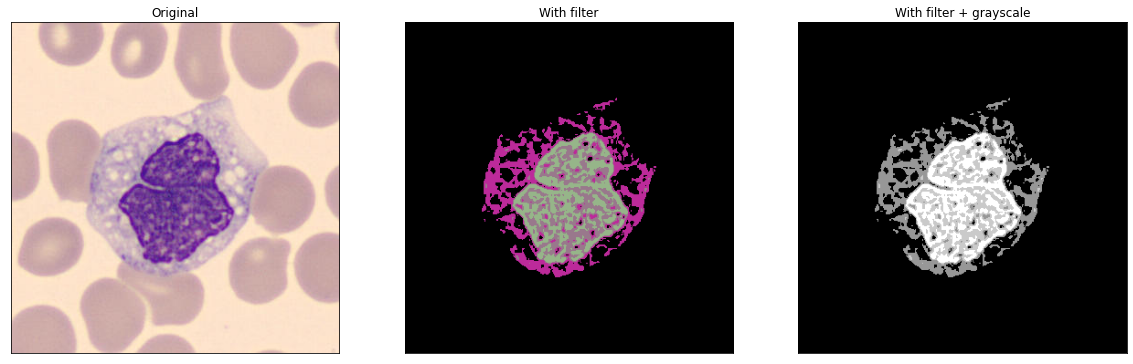

In [8]:
# On choisit K means K=6 pour avoir suffisamment de nuance de gris sur la cellule sélectionnée
# file = df[df.cell_type_code=='MO'].filename.values[100]
# print(file)
# file='data\PBC_dataset_normal_DIB\ig\IG_761306.jpg'
file='dataset\PBC_dataset_normal_DIB\monocyte\MO_155861.jpg'
img = cv2.imread(file,cv2.IMREAD_COLOR)
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# convert with Kmeans filters
# img1, elapsed = OTSU_threshold(img,composant='B')
# img1, elapsed = filter_MeanShift(img)
img1, elapsed = filter_Kmeans2(img,n_clusters=4)
print(img1.shape)

# convert in grayscale
# rgb_weights = [1/3, 1/3, 1/3]
rgb_weights = [0.2989, 0.5870, 0.1140]
img_gray = np.dot(img1[...,:3], rgb_weights)
# img2= img1.mean(axis=0)

plt.figure(figsize = (20, 10))

plt.subplot(1,3,1)
plt.imshow(imgRGB,cmap = 'gray')
plt.xticks([]), plt.yticks([]), plt.title('Original')

plt.subplot(1,3,2)
plt.imshow(img1,cmap = 'gray')
plt.xticks([]), plt.yticks([]), plt.title('With filter')

plt.subplot(1,3,3)
plt.imshow(img_gray,cmap = 'gray')
plt.xticks([]), plt.yticks([]), plt.title('With filter + grayscale')

plt.show()

#### Formation du dataset pour l'entrainement

Récupération des informations sur la base de données

In [7]:
# path='dataset/PBC_dataset_normal_DIB/'
path='variables/'
img_info = pd.read_csv(path + 'img_info.csv')
cell_types = pd.read_csv(path + 'cell_types.csv')
cell_types['cell_type3']=cell_types.cell_type_code + ' - ' + cell_types.cell_type2
# cell_types = cell_types[cell_types.Source=='article'].drop(columns=['Source'])
df = pd.merge(img_info,cell_types,how='outer') # merge on column cell_subtype
# display(df.head())

# # nombre d'images:
print('nb d\'images:',len(df),'\n')
# distribution des types de cellules:
print(df.cell_type3.value_counts(normalize=True).round(4)*100)

print('\nnb de noms d\'images uniques:',len(df.img_name.unique())) # les noms d'image sont bien uniques et peuvent être utilisés comme clé

nb d'images: 17094 

NE - neutrophils              19.48
EO - eosinophils              18.23
IG - immature granulocytes    16.94
PL - thrombocytes             13.74
ER - erythroblasts             9.07
MO - monocytes                 8.31
BA - basophils                 7.13
LY - lymphocytes               7.10
Name: cell_type3, dtype: float64

nb de noms d'images uniques: 17094


**Boucle sur un échantillon de la base de données**

On commence par définir une liste d'indices des lignes que nous allons traiter. On définit un nombre de cellules à traiter par catégorie, et on les sélectionne au hasard parmi la catégorie, puis une boucle traite chaque image et lui applique le filtre ci-dessus et stock la sortie dans une matrice data.

In [9]:
# pour ignorer les warnings
import warnings
warnings.filterwarnings("ignore")

npc=200 # nombre d'images par catégorie de cellule à scanner et filtrer
filter='Kmeans2' #filter Options : 'Kmeans1','Kmeans2','OTSU','MeanShift'

# On récupère les dimensions du format d'image le plus fréquent:
h=int(df.img_dim.mode()[0].split(' x ')[0])
w=int(df.img_dim.mode()[0].split(' x ')[1])

# Création d'une liste d'index à scanner dans le dataframe
cell_types = df.cell_type_code.value_counts().index # cell types sorted by number of apparitions in the dataset

# index selection:
selected_index=[]
for ct in cell_types: 
    all_index_ct=df[df.cell_type_code==ct].index
    new_selected_index=np.random.choice(all_index_ct, size=npc) # on en choisit npc par cell_type (npc= nombre de cellules)
    selected_index=np.concatenate([selected_index,new_selected_index]).astype(int)
    

# On process pour chacun de ces indexes:

data =[]

start = time.time()

# tqdm pour la barre d'avancement
for i in tqdm(selected_index):

    p_start = time.time()
    
    filename =df.loc[i,'filename'].replace('data\\','dataset\\') # Le nom du dossier a changé de data à dataset
    img_height =df.loc[i,'img_height'] # hauteur de l'image
    img_width =df.loc[i,'img_width']
    
    # img = cv2.imread(filename,cv2.IMREAD_GRAYSCALE)
    img = cv2.imread(filename,cv2.IMREAD_COLOR)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # on redimensionne l'image si elle n'est pas à la taille classique calculée ci-dessus
    if (img_height,img_width) != (h, w):
        # certaines images ne peuvent pas être redimensionnées d'où l'utilisation de try:
        try:
            img = cv2.resize(img, dsize = (h,w), interpolation = cv2.INTER_LINEAR)
        except Exception as e:
            print('impossible to reshape',filename,'for the following reason:\n',str(e))
            # on supprime ce fichier de notre base de données car nous ne pourrons pas l'intégrer à notre modèle:
            df=df[df.filename != filename]
            print('The image was deleted from database.')
    
    if filter == 'Kmeans1':
        
        # convert with Kmeans filter
        img1, _ = filter_Kmeans1(img,n_clusters=6,bckgrd=False)

        # convert in grayscale
        rgb_weights = [1/3, 1/3, 1/3]  # [0.2989, 0.5870, 0.1140] => to play with gray shades
        img_gray = np.dot(img1[...,:3], rgb_weights)

    elif filter == 'Kmeans2':
        
        # convert with Kmeans filter
        img1, _ = filter_Kmeans2(img,n_clusters=4)

        # convert in grayscale
        rgb_weights = [1/3, 1/3, 1/3]  # [0.2989, 0.5870, 0.1140] => to play with gray shades
        img_gray = np.dot(img1[...,:3], rgb_weights)
    
    elif filter == 'OTSU':
        
        img_gray, _ = OTSU_threshold(img,composant='S',blur=False)
        
    elif filter == 'MeanShift':
        
        # convert with Kmeans filter
        img1, _ = filter_MeanShift(img)

        # convert in grayscale
        rgb_weights = [1/3, 1/3, 1/3]  # [0.2989, 0.5870, 0.1140] => to play with gray shades
        img_gray = np.dot(img1[...,:3], rgb_weights)

    # convert in an array
    h,w=img_gray.shape
    X=img_gray.reshape(1,h*w)[0]
    
    # process time
    p_end = time.time()
    p_elapsed = p_end - p_start
    
    # label:
    img_name = [df.loc[i,'img_name']]
    # process_time=[round(p_elapsed,6)]
    label = [df.loc[i,'cell_type3']]
    
    # store in data
    # data.append(np.concatenate((img_name,process_time,label,X),axis=0))
    data.append(np.concatenate((img_name,label,X),axis=0))
    
    # print information on advancement
    # print(f'file processed : {filename}. Process time : {round(p_elapsed,2):0} s.')
    

end = time.time()
elapsed = end - start
print(f'Time elapsed : {elapsed//60 :0}min {round(elapsed % 60,0):0}sec')

100%|██████████| 1600/1600 [25:36<00:00,  1.04it/s]

Time elapsed : 25.0min 37.0sec


**Transformation de data en dataframe**

In [13]:
# np.transpose(data)

array([['SNE_800425.jpg', 'SNE_181877.jpg', 'BNE_39101.jpg', ...,
        'LY_44395.jpg', 'LY_508185.jpg', 'LY_874360.jpg'],
       ['NE - neutrophils', 'NE - neutrophils', 'NE - neutrophils', ...,
        'LY - lymphocytes', 'LY - lymphocytes', 'LY - lymphocytes'],
       ['0.0', '0.0', '0.0', ..., '0.0', '134.33333333333331', '0.0'],
       ...,
       ['0.0', '0.0', '0.0', ..., '0.0', '130.0', '0.0'],
       ['0.0', '0.0', '0.0', ..., '0.0', '130.0', '0.0'],
       ['0.0', '0.0', '0.0', ..., '0.0', '130.0', '0.0']], dtype='<U32')

In [14]:
col_names= np.concatenate( (['img_name','process_time','label'],['p'+str(i) for i in range(1,h*w+1)]),axis=0)
# data_df=pd.DataFrame(data,columns = col_names)
# data_df.label.value_counts()
data_df=pd.DataFrame(data,columns = col_names).T #on transpose directement

**Sauvegarde sous un fichier csv (transposé)**

In [ ]:
save_var_name = 'variables/data_'+filter+'_sample'+str(npc)
# (data_df.T).to_csv(save_var_name+'.csv')
data_df.to_csv(save_var_name+'.csv') # si on a déjà transposé

### 7.2. Récupération des données et entrainement

#### Récupération des données

In [ ]:
import time
import pandas as pd
import numpy as np
import glob

from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from sklearn import model_selection
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

In [ ]:
# savename = 'variables/data_otsu_sample200' # database save name
savename = 'variables/data_'+filter+'_sample'+str(npc) # database save name

start = time.time()
    
# pour ignorer le problème de mémoire souvent rencontré
import warnings
warnings.filterwarnings("ignore")

# on lit le csv et le transpose directement
data=pd.read_csv(savename+'.csv',index_col=0).T

end = time.time()
elapsed = end - start
print(f'Time elapsed : {elapsed//60}min {round(elapsed % 60,0)}sec for {len(data):0} images (= {round(len(data)/17092*100,2):0}% of the total dataset).')

In [ ]:
data.head()

In [ ]:
data.info()

#### Séparation des features des variables cibles

In [ ]:
target = data['label'].apply(lambda x: x.split(' - ')[0])
feats = data.iloc[:,3:]

#### PCA

In [ ]:
pca=PCA(n_components =0.9).fit(feats)
print('number of pixels kept:',pca.n_components_)
feats_pca=pca.transform(feats)

#### Définition d'une fonction de rapport cible

In [ ]:
def modeling(features,target,model,display_results_list):

    start = time.time()
    
    X_train, X_test, y_train, y_test= train_test_split(features, target, test_size=0.2,shuffle=True,random_state=123)

    model.fit(X_train, y_train)
    y_pred_train=model.predict(X_train)
    y_pred_test=model.predict(X_test)
    
    if 'confusion_matrix' in display_results_list:
        cm_train = pd.crosstab (y_train, y_pred_train, rownames=['Reality'], colnames=['Prediction'])
        display(cm_train)
        
    if 'classification_report' in display_results_list:
        print('CLASSIF ON TRAIN:\n\n',
              classification_report(y_train, y_pred_train))
    
    if 'confusion_matrix' in display_results_list:
        cm_test = pd.crosstab (y_test, y_pred_test, rownames=['Reality'], colnames=['Prediction'])
        display(cm_test)
        
    if 'classification_report' in display_results_list:
        print('CLASSIF ON TEST:\n\n',
              classification_report(y_test, y_pred_test))

    if 'scores' in display_results_list:
        acc_train=model.score(X_train, y_train) # retourne l'accuracy du dataset d'entrainement
        acc_test=model.score(X_test, y_test) # retourne l'accuracy du dataset d'entrainement
        print('ACCURACIES:\n',
              '\n train dataset :', round(acc_train*100,2),'%',
              '\n test dataset :', round(acc_test*100,2),'%')

### 7.3. Machine Learning on filter OTSU threshold

#### 7.3.1. SVM

In [ ]:
# SVM with PCA:
modeling(feats_pca,target,svm.SVC(),('classification_report','scores'))

Nous sommes face à un surapprentissage.

#### 7.3.2. Random Forest

In [ ]:
# Random Forest with PCA:
modeling(feats_pca,target,RandomForestClassifier(),('classification_report','scores'))

In [ ]:
# Random Forest without PCA:
# modeling(feats,target,RandomForestClassifier(),('classification_report','scores'))

Nous sommes face à un TOTAL surapprentissage.

### 7.4. Machine Learning on filter Kmeans

#### 7.4.1. Import données / PCA

In [ ]:
savename = 'variables/data_kmeans1_sample200' # database save name

start = time.time()

# on lit le csv et le transpose directement
data=pd.read_csv(savename+'.csv',index_col=0).T

end = time.time()
elapsed = end - start
print(f'Time elapsed : {elapsed//60}min {round(elapsed % 60,0)}sec for {len(data):0} images (= {round(len(data)/17092*100,2):0}% of the total dataset).')

In [ ]:
data['label'].value_counts()

In [ ]:
data.info()

In [ ]:
target = data['label'].apply(lambda x: x.split(' - ')[0])
feats = data.iloc[:,3:]
pca=PCA(n_components =0.9).fit(feats)
print('number of pixels kept:',pca.n_components_)
feats_pca=pca.transform(feats)

#### 7.4.2. SVM

In [ ]:
# SVM with PCA:
modeling(feats_pca,target,svm.SVC(),('classification_report','scores'))

In [ ]:
# SVM without PCA:
# modeling(feats,target,svm.SVC(),('classification_report','scores'))

#### 7.4.3. Random Forest

In [ ]:
# Random Forest with PCA:
modeling(feats_pca,target,RandomForestClassifier(),('classification_report','scores'))

In [ ]:
# Random Forest without PCA:
# modeling(feats,target,RandomForestClassifier(),('classification_report','scores'))

### 7.5. Machine Learning on filter MeanShift

#### 7.5.1. Import données & PCA

In [ ]:
savename = 'variables/data_MeanShift_sample10' # database save name

start = time.time()

# on lit le csv et le transpose directement
data_ms=pd.read_csv(savename+'.csv',index_col=0).T

end = time.time()
elapsed = end - start
print(f'Time elapsed : {elapsed//60}min {round(elapsed % 60,0)}sec for {len(data):0} images (= {round(len(data)/17092*100,2):0}% of the total dataset).')

In [ ]:
data_ms['label'].value_counts()

In [ ]:
data_ms.info()

In [ ]:
target = data_ms['label'].apply(lambda x: x.split(' - ')[0])
feats = data_ms.iloc[:,3:]
pca=PCA(n_components =0.9).fit(feats)
print('number of pixels kept:',pca.n_components_)
feats_pca=pca.transform(feats)

#### 7.5.2. SVM

In [ ]:
# SVM with PCA:
modeling(feats_pca,target,svm.SVC(),('classification_report','scores'))

#### 7.5.3. Random Forest

In [ ]:
# Random Forest with PCA:
modeling(feats_pca,target,RandomForestClassifier(),('classification_report','scores'))

### 7.6. Machine Learning sur images en noir et blanc sans filtre

#### 7.6.1. Import données

In [ ]:
savename = 'variables/data_nofilter_sample200' # database save name

start = time.time()

# on lit le csv et le transpose directement
data_gray=pd.read_csv(savename+'.csv',index_col=0).T

end = time.time()
elapsed = end - start
print(f'Time elapsed : {elapsed//60}min {round(elapsed % 60,0)}sec for {len(data):0} images (= {round(len(data)/17092*100,2):0}% of the total dataset).')

In [ ]:
data_gray['label'].value_counts()

In [ ]:
data_gray.info()

In [ ]:
target = data_gray['label'].apply(lambda x: x.split(' - ')[0])
feats = data_gray.iloc[:,3:]
pca=PCA(n_components =0.9).fit(feats)
print('number of pixels kept:',pca.n_components_)
feats_pca=pca.transform(feats)

#### 7.6.2. SVM

In [ ]:
# SVM with PCA:
modeling(feats_pca,target,svm.SVC(),('classification_report','scores'))

#### 7.6.3. Random Forest

In [ ]:
# Random Forest with PCA:
modeling(feats_pca,target,RandomForestClassifier(),('classification_report','scores'))